Focus this notebook on evaluation of similarities of topics in learned models.

### Import packages

In [1]:
import os
import glob
import zipfile
import shutil
import re
import string
from sklearn.feature_extraction.text import CountVectorizer
import scipy.stats as stats
import datetime
import pylab as pl
import math
import codecs
import nltk
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import time
import json
import gensim
from gensim import corpora, models
from gensim.matutils import hellinger
from gensim.models.coherencemodel import CoherenceModel
import logging
%matplotlib inline

### Set all important file paths

In [2]:
pwd()

u'/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project'

In [8]:
# Richard path specs

# # At work:
# TEXT_PATH = "T:/Quant/TextAnalysis/Transcripts/SP100/Text/"
# PDF_PATH = "T:/Quant/TextAnalysis/Transcripts/SP100/PDF/"
# LIBRARY_PATH = "T:/Quant/TextAnalysis/Transcripts/SP100/Libraries/"

# # At home:
# dict_path = '/Users/Richard/Desktop/Berkeley/w266/'
# input_path = '/Users/Richard/Desktop/Berkeley/w266/repo/w266_project/'
# output_path = '/Users/Richard/Desktop/Berkeley/w266/'

# LIBRARY_PATH = '/Users/Richard/Desktop/Berkeley/w266/repo/w266_project/'



In [3]:
# Tom path specs

# Tom machine:
TEXT_DIR_LIST = ["T1", "T2", "T3", "T4"]
# PDF_PATH = "T:/Quant/TextAnalysis/Transcripts/SP100/PDF/"
LIBRARY_PATH = "/Users/seddont/Dropbox/Tom/MIDS/W266_work/w266_project/"

# On Tom's google cloud instance
# LIBRARY_PATH = "/home/seddon/w266_project/"



In [4]:
class Saved_state():
    '''Represents a saved state that includes an LDA model and the data used to create it.
    
       Instantiated with a model_spec dictionary that locates the files to 
       recreate the saved state and includes a description.
       
       Dictionary needs to contain:
       
       model_files
       qa_pairs_file
       raw_qa_text_file
       corpus_file
       hellinger_file
       '''
    def __init__(self, model_spec):
        
        model_dir = LIBRARY_PATH+model_spec["model_directory"]
        qa_dir = LIBRARY_PATH+model_spec["qa_pair_directory"]
        
        self.ldamodel = gensim.models.ldamodel.LdaModel.load(model_dir+"/full_model")
        
        self.dictionary = gensim.corpora.dictionary.Dictionary.load(model_dir+"/dictionary.txt")
        
        with open(qa_dir+"/qa_pairs.txt", "r") as f:
            self.qa_pairs = json.loads(f.read())
            
        with open(LIBRARY_PATH + "/raw_qa_data.txt", "r") as f:
            self.raw_qa_text = json.loads(f.read())
            
        with open(model_dir+"/corpus.txt", "r") as f:
            self.corpus = json.loads(f.read())
            
        with open(model_dir+"/hell_sims.txt", "r") as f:
            self.hellinger_sims = json.loads(f.read())
            
        with open(model_dir+"/model_runtime.txt", "r") as f:
            self.model_runtime = f.read()

In [ ]:
def get_topic_sims_results(model_dir):
    
    topic_sims_results = {}
    
    with open(LIBRARY_PATH+"saved_models/"+model_dir+"/hell_sims.txt") as f:
        hellinger_sims = json.loads(f.read())    
    
    for file_id in hellinger_sims:
        ticker, date = file_id.split('_')

        if date not in topic_sims_results.keys():
            topic_sims_results[date] = {}

        avg_sim = np.mean([hellinger_sims[file_id][q_num] for q_num in hellinger_sims[file_id]])

        topic_sims_results[date][ticker] = avg_sim
        
    return topic_sims_results

In [5]:
model_dir = "Check_top40_len40_prebase"

with open(LIBRARY_PATH+"saved_models/"+model_dir+"/hell_sims.txt") as f:
    hellinger_sims = json.loads(f.read())    

Mean similarity 0.48690074745
SD similarity 0.089699009501


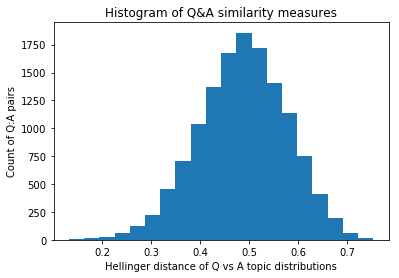

In [8]:
all_sims = []
for file_id in hellinger_sims:
    for q_number in hellinger_sims[file_id]:
        all_sims.append((hellinger_sims[file_id][q_number],(file_id, q_number)))

sim_vals = [v[0] for v in all_sims]
print "Mean similarity", np.mean(sim_vals)
print "SD similarity", np.std(sim_vals)

plt.hist(sim_vals, bins = 20)
plt.xlabel("Hellinger distance of Q vs A topic distributions")
plt.ylabel("Count of Q:A pairs")
plt.title("Histogram of Q&A similarity measures")

In [9]:
with open(LIBRARY_PATH+"saved_models/"+model_dir+"/topic_dists.txt") as f:
    topic_dists = json.loads(f.read())

In [10]:
topic_dists

{u'SPG_20120724_6_q': [[7, 0.23546088607838422],
  [8, 0.07337292558061344],
  [15, 0.02949973487273473],
  [17, 0.031088934523590656],
  [23, 0.06146809616610073],
  [24, 0.28692756011036136],
  [33, 0.1942199123906525],
  [35, 0.06935729911477201]],
 u'SPG_20120724_6_a': [[2, 0.022499731107963425],
  [7, 0.5245695841880478],
  [8, 0.3913920532176839],
  [9, 0.02185489436089556],
  [35, 0.021454570458743497]],
 u'CVX_20100730_15_a': [[1, 0.016803278688524603],
  [3, 0.07969036674470684],
  [5, 0.08998093616748813],
  [7, 0.34970392605211215],
  [11, 0.02538019616171722],
  [25, 0.04413987089442212],
  [28, 0.02270455059386213],
  [32, 0.31182213344824866],
  [35, 0.016803278688524603],
  [36, 0.030676380593181184]],
 u'HSH_20120503_9_q': [[0, 0.3656766991570581],
  [3, 0.06305698895369188],
  [9, 0.07892156862745105],
  [10, 0.06212877399997555],
  [14, 0.08417569368987117],
  [23, 0.17755726142716094],
  [25, 0.08577355994337033],
  [31, 0.023318862941143687],
  [36, 0.04419451282890

In [14]:
len(hellinger_sims)

2769

In [12]:
all_dist_list = []

for t in topic_dists:
    all_dist_list.append(topic_dists[t])
    
len(all_dist_list)

26490

## to do  

draw randomly from all_dists
(maybe only pick from dists where the file id and q num is in hellinger sims i.e. meets the min sequence length requirements)

make pairs of q and a

calculate hellinger distance for the pairs
(time this vs n done)

Create a distribution of the distances

Compare the distribution to the one we see.

